### **This jupyter notebook contains the code for training cnn algorithms for detection of the pneumonia from the images.(FASTAI)**

### Author : Umidjon Sattorov Machine learning engineer and successfull graduator of the course from Skillbox platform, student at Mohirdev platform

**Installing important libraries**

In [2]:
!pip install fastai

     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.6 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.6 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.6 kB ? eta -:--:--
     -------------------- ----------------- 30.7/57.6 kB 187.9 kB/s eta 0:00:01
     -------------------- ----------------- 30.7/57.6 kB 187.9 kB/s eta 0:00:01
     -------------------- ----------------- 30.7/57.6 kB 187.9 kB/s eta 0:00:01
     -------------------------------------- 57.6/57.6 kB 217.0 kB/s eta 0:00:00
     ---------------------------------------- 0.0/125.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/125.2 kB ? eta -:--:--
     --- ------------------------------------ 10.2/125.2 kB ? eta -:--:--
     --- ------------------------------------ 10.2/125.2 kB ? eta -:--:--
     --- --------------

In [3]:
#Installing yolov8 model 
!pip install yolov8_model

ERROR: Could not find a version that satisfies the requirement yolov8_model (from versions: none)
ERROR: No matching distribution found for yolov8_model


**Data preprocessing**

In [2]:
#Importing necessary modules and libraries first
import fastai as fst
import torch
from fastai.vision.all import *
from ipywidgets import widgets
from sklearn.metrics import roc_auc_score, roc_curve
from io import BytesIO

#Yolov8 model implementation libraries
import torch.nn as nn
from yolov8_model import YOLOv8

ModuleNotFoundError: No module named 'yolov8_model'

In [2]:
#Veritification if general processing unit is activated
torch.cuda.is_available()

False

In [13]:
#Quick check of the versions of the libraries
print(torch.__version__)
print(fst.__version__)

2.3.1+cpu
2.7.15


**Training machine learning model**

In [6]:
#data path
path = Path('./data/train')
fls = get_image_files(path)
fls

(#5216) [Path('data/train/NORMAL/IM-0115-0001.jpeg'),Path('data/train/NORMAL/IM-0117-0001.jpeg'),Path('data/train/NORMAL/IM-0119-0001.jpeg'),Path('data/train/NORMAL/IM-0122-0001.jpeg'),Path('data/train/NORMAL/IM-0125-0001.jpeg'),Path('data/train/NORMAL/IM-0127-0001.jpeg'),Path('data/train/NORMAL/IM-0128-0001.jpeg'),Path('data/train/NORMAL/IM-0129-0001.jpeg'),Path('data/train/NORMAL/IM-0131-0001.jpeg'),Path('data/train/NORMAL/IM-0133-0001.jpeg')...]

In [7]:
#Checking if there are not any fatally damaged images in the dataset
failed = verify_images(path)
failed

'WindowsPath' object is not iterable


(#0) []

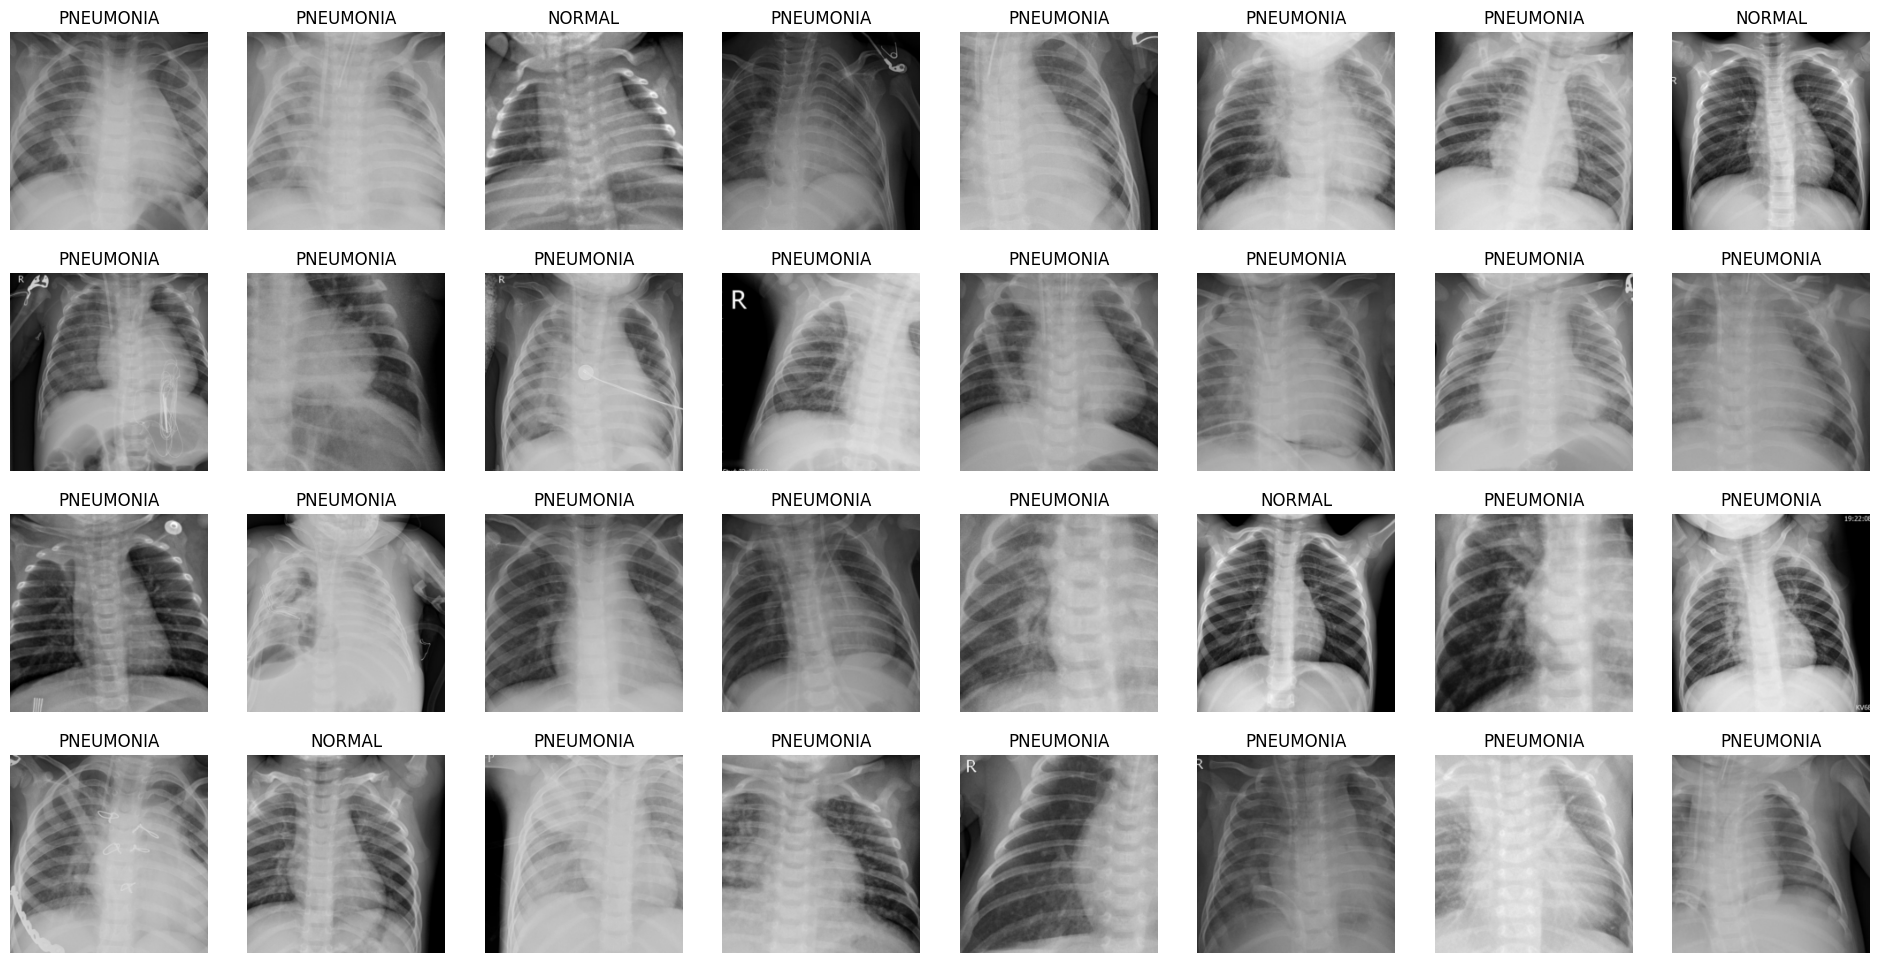

In [14]:
#Creating data block for data model
pn_dis = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
    get_y = parent_label,
    item_tfms = Resize(224)
)

#Creating dataloaders from datablock
dls = pn_dis.dataloaders(path)
dls.train.show_batch(max_n = 32, nrows = 4)

In [22]:
#Adding additional metrics here
class RocAuc(Metric):
    def reset(self):
        self.y_true = []
        self.y_pred = []

    def accumulate(self, learn):
        preds = learn.pred.softmax(dim=1)[:, 1].cpu().numpy() 
        targs = learn.y.cpu().numpy()
        self.y_true.extend(targs)
        self.y_pred.extend(preds)

    @property
    def value(self):
        if len(set(self.y_true)) == 1: 
            return 1.0  
        return roc_auc_score(self.y_true, self.y_pred)

In [23]:
#Modellng 
learn = cnn_learner(dls, resnet34, metrics = [accuracy, RocAuc()])
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,roc_auc,time
0,0.177670,0.124045,0.960690,0.996941,08:56
1,0.099854,0.089354,0.966443,0.994952,09:25
2,0.049038,0.041397,0.985618,0.998852,09:47
3,0.026816,0.036612,0.986577,0.999111,10:04


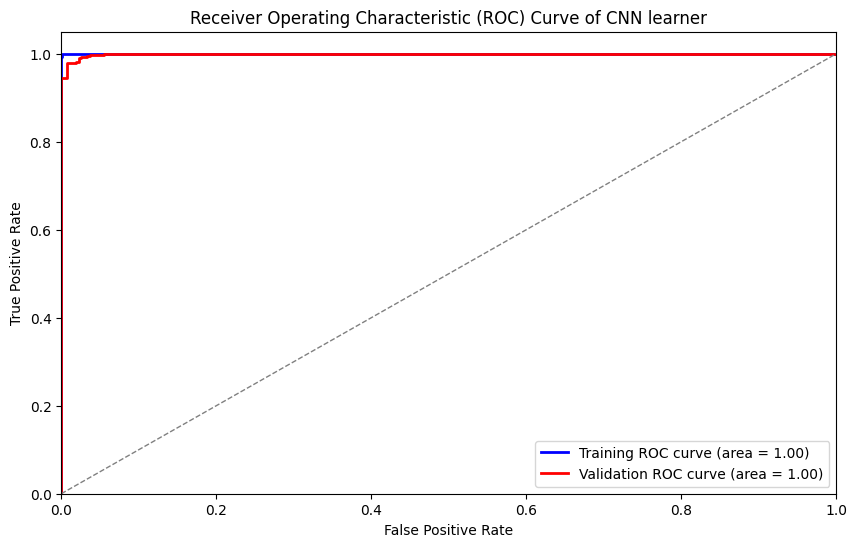

In [25]:
#Getting predictions from the dataset
train_preds, train_targs = learn.get_preds(ds_idx = 0)
train_probs = train_preds.softmax(dim = 1)[ : , 1].cpu().numpy()
train_targs = train_targs.cpu().numpy()

valid_preds, valid_targs = learn.get_preds(ds_idx = 1)
valid_probs = valid_preds.softmax(dim = 1)[ : , 1].cpu().numpy()
valid_targs = valid_targs.cpu().numpy()

fpr_train, tpr_train, _ = roc_curve(train_targs, train_probs)
roc_auc_train = roc_auc_score(train_targs, train_probs)

fpr_valid, tpr_valid, _ = roc_curve(valid_targs, valid_probs)
roc_auc_valid = roc_auc_score(valid_targs, valid_probs)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training ROC curve (area = {roc_auc_train:.2f})')
plt.plot(fpr_valid, tpr_valid, color='red', lw=2, label=f'Validation ROC curve (area = {roc_auc_valid:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of CNN learner')
plt.legend(loc="lower right")
plt.show()

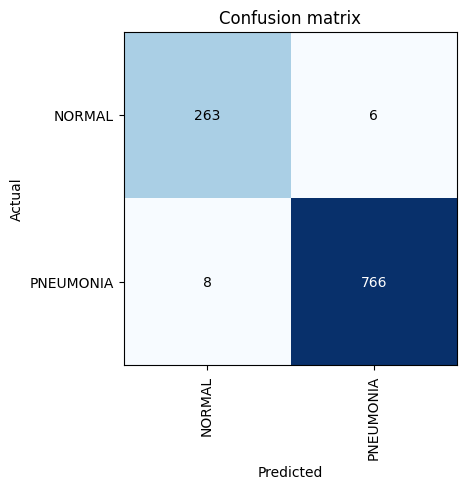

In [43]:
#Verification of the model
interp = ClassificationInterpretation.from_learner(learn = learn)
interp.plot_confusion_matrix()

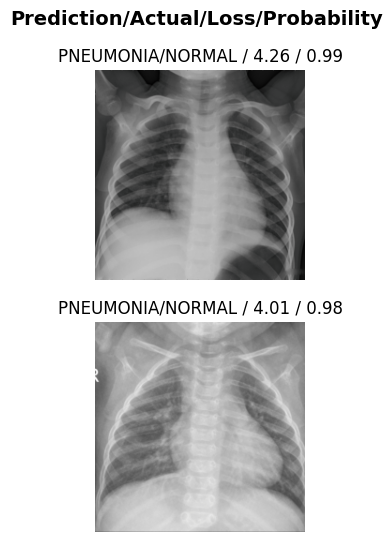

In [48]:
#Incorrect predictions from the model
interp.plot_top_losses(2, nrows = 2)

**Evaluation of the model**

In [50]:
#Evaluation of the model
upload = widgets.FileUpload()
upload

FileUpload(value=(), description='Upload')

In [ ]:
img = PILImage.create(BytesIO(upload.value[-1].content))
pred, pred_id, probs = learn.predict(item = img)
print(f"Prediction Element : {pred}")
print(f"Probability rate : {probs[pred_id]}")
img